---
## AI-Model Testing + Hyperparameter Einstellung
by Tobia Ippolito
### Contents:
- [Imports](#0.0)
- [Big Testing](#0.5)
- [10-fold-Crossvalidation](#1.0)
- [SVC](#2.0)
- [AdaBoost](#2.5)
- [Naive Bayes](#2.6)
- [Logistic Regression](#2.7)
- [KNN](#3.0)
- [RandomForest](#4.0)
- [VotingClassifier](#5.0)
<br>
<br>
In dieser Datei werden verschiedene ML_Algorithmen auf ihre Accuracy untersucht und ihre Hyperparameter eingestellt. <br>Es wurde auf eine saubere Trennung von Trainings-, Validierungs- und Testdaten geachtet.
<br>
<br>
---
### <a name='0.0'>Imports</a>

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../../src')

In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import anoog
from anoog.model import MODELS
from anoog.model import evaluate_model_with_cross_validation
from anoog.model import evaluate_model
from anoog.model import get_most_important_features
from anoog.model import train_random_forest, train_svc, train_knn, train_naive_bayes, train_adaboost, train_logistic_regression, train_voting_classifier

---
### <a name='0.5'>Big Testing</a>
load data

In [118]:
data = anoog.io.load_data("../../data/2021-11-09",
                                ['tippolit', 'vkorzev'],
                                extraction=anoog.io.extraction_mode.MANUEL,
                                selection=anoog.io.selection_mode.NONE,
                                train_test_split=False)

In [127]:
X,y = anoog.io.X_y_split(data)

# test traindata size -> testsize config
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.87, stratify=y)
len(X_train)

6

In [151]:
def plot_boxplot(results, n_datasets):
    fig = plt.figure()
    ax = plt.axes()

    fig.set_size_inches(18, 10)
    fig.suptitle(f"Model Evaluation with diffrent data-constellations (trainsize = 6, datasets={n_datasets})", fontsize=18)

    plt.style.use('seaborn-whitegrid')

    ax.boxplot(results.values(), vert=False, labels=results.keys())
    ax.set_xlabel("Accuracy")

In [142]:
amount_of_experiments = 100
models = {'Random Forest':train_random_forest, 'SVC':train_svc, 'KNN':train_knn, 'Naive Bayes':train_naive_bayes, 'Ada Boost':train_adaboost, 'Logistic Regression':train_logistic_regression, 'Voting Classifier':train_voting_classifier}
results = {'Random Forest':[], 'SVC':[], 'KNN':[], 'Naive Bayes':[], 'Ada Boost':[], 'Logistic Regression':[], 'Voting Classifier':[]}
for i in range(amount_of_experiments):
    # create new split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.87, stratify=y)     # len of train should be 6 how it is in real

    for model, fit_method in models.items():
        # train
        cur_model = fit_method(X_train, y_train, auto_params=False, normalize=True)

        # evaluate
        results[model] += [evaluate_model(cur_model, X_test, y_test, X_train, normalize=True)[0]]

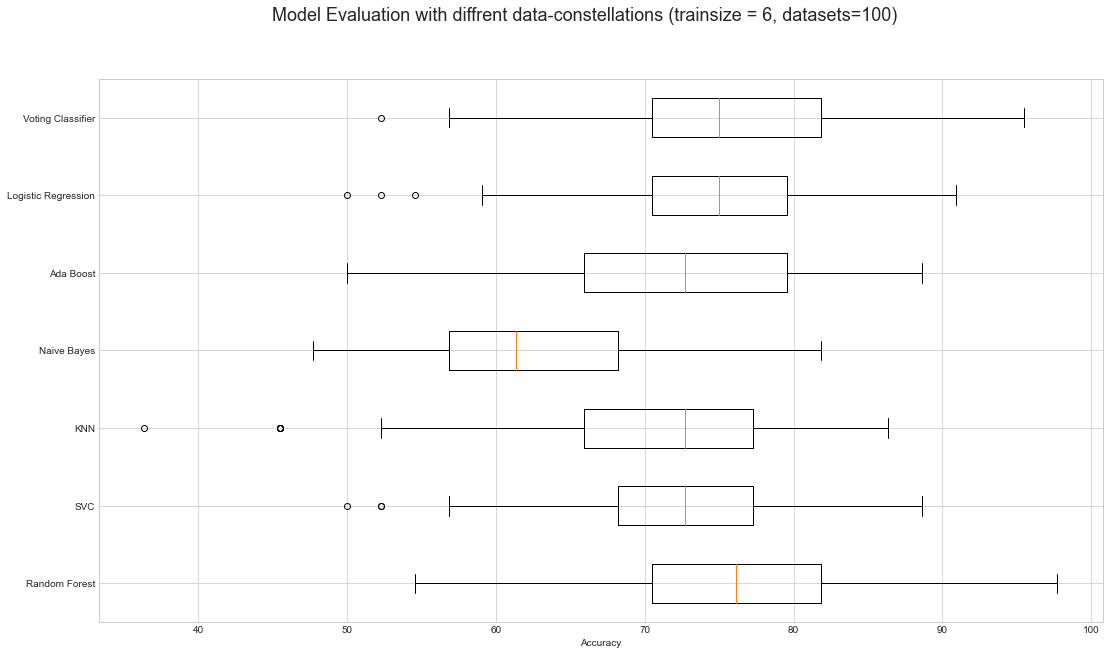

In [152]:
plot_boxplot(results, amount_of_experiments)

---
### <a name='1.0'>10-fold-Crossvalidation</a>

In [3]:
data = df = anoog.io.load_data("../../data/2021-11-09",
                        ['tippolit', 'vkorzev'],
                        extraction=anoog.io.extraction_mode.MANUEL,
                        selection=anoog.io.selection_mode.NONE,
                        train_test_split=False,
                        normalize=True)
data.tail()

,audio_min,audio_max,audio_mean,audio_median,audio_std,current_min,current_max,current_mean,current_median,current_std,...,voltage_mean,voltage_median,voltage_std,Time,Resistance,Power,Work,mAh,Wh,y
45,0.499970,0.524153,0.546429,0.486107,0.498624,0.981361,0.794324,0.099471,0.051765,0.403033,...,0.262847,0.322230,0.370096,0.629174,0.098147,0.100821,0.280750,0.099471,0.100821,1.0
46,0.501927,0.519836,0.631510,0.485915,0.462201,0.950122,0.780712,0.106452,0.104558,0.384292,...,0.254285,0.310874,0.346838,0.521968,0.105264,0.107660,0.118180,0.106452,0.107660,1.0
47,0.703289,0.393621,0.512861,0.487407,0.263667,0.420836,0.000000,0.000000,0.031463,0.000000,...,0.274758,0.294388,0.000000,0.760984,0.000000,0.000000,0.166171,0.000000,0.000000,1.0
48,0.502029,0.513907,0.577089,0.486803,0.431190,0.420836,0.876737,0.173159,0.130077,0.436350,...,0.196933,0.256548,0.390586,0.520211,0.172791,0.173515,0.288815,0.173159,0.173515,1.0
49,0.792630,0.469935,0.792698,0.454811,0.339974,0.420836,0.862295,0.216525,0.194656,0.407967,...,0.157877,0.198933,0.368864,0.534271,0.216968,0.216049,0.429380,0.216525,0.216049,1.0


In [4]:
X,y = anoog.io.X_y_split(data)
X.head()

,audio_min,audio_max,audio_mean,audio_median,audio_std,current_min,current_max,current_mean,current_median,current_std,...,voltage_max,voltage_mean,voltage_median,voltage_std,Time,Resistance,Power,Work,mAh,Wh
0,0.489226,0.539696,0.620803,0.488007,0.589802,0.841672,0.903051,0.081916,0.047550,0.342350,...,1.000000,1.000000,1.000000,0.387944,0.984183,0.061104,0.104178,0.892324,0.081916,0.104178
1,0.948940,0.078485,0.737151,0.497329,0.000000,0.912990,0.870149,0.478445,0.668963,0.707884,...,0.894985,0.701696,0.586562,0.730675,0.356766,0.450447,0.507766,0.700566,0.478445,0.507766
2,0.554606,0.519374,0.720443,0.496879,0.187601,0.841672,0.971043,0.673538,0.751618,0.726680,...,0.865587,0.585654,0.542533,0.742611,0.191564,0.644603,0.703628,0.554519,0.673538,0.703628
3,0.500641,0.526755,0.598239,0.488965,0.406655,0.841672,0.902161,0.093400,0.079668,0.351717,...,0.851916,0.882752,0.883772,0.364501,0.736380,0.075100,0.112851,0.500696,0.093400,0.112851
4,0.000000,0.532166,0.317739,0.452649,0.614912,0.420836,0.807761,0.452521,0.502235,0.487880,...,0.836230,0.677153,0.600962,0.506825,0.353251,0.426599,0.479638,0.630015,0.452521,0.479638


In [5]:
evaluate_model_with_cross_validation(X, y, model=MODELS.RANDOM_FOREST)

array([0.7, 0.8, 1. , 1. , 0.7])

In [6]:
evaluate_model_with_cross_validation(X, y, model=RandomForestClassifier())

array([0.6, 0.8, 1. , 1. , 0.8])

In [7]:
evaluate_model_with_cross_validation(X, y, model=MODELS.SVM)

array([1. , 0.8, 0.9, 1. , 0.8])

In [8]:
evaluate_model_with_cross_validation(X, y, model=MODELS.KNN)

array([0.7, 0.6, 0.5, 0.9, 0.8])

In [9]:
evaluate_model_with_cross_validation(X, y, model=MODELS.LOGISTIC_REGRESSION)

array([0.8, 0.8, 0.8, 1. , 0.8])

In [10]:
evaluate_model_with_cross_validation(X, y, model=MODELS.ADA_BOOST)

array([0.6, 1. , 1. , 0.7, 0.5])

In [11]:
evaluate_model_with_cross_validation(X, y, model=MODELS.NAIVE_BAYES)

array([0.8, 0.7, 0.7, 0.9, 0.8])

In [12]:
evaluate_model_with_cross_validation(X, y, model=MODELS.VOTING_CLASSIFIER)

array([0.6, 0.7, 1. , 1. , 0.8])

---
### <a name='2.0'>**S**upport **V**ector **C**lassifier</a>
Good with high dimensions, normlizing because the distance

get best params

In [13]:
data = df = anoog.io.load_data("../../data/2021-11-09",
                        ['tippolit', 'vkorzev'],
                        extraction=anoog.io.extraction_mode.MANUEL,
                        selection=anoog.io.selection_mode.NONE,
                        train_test_split=False,
                        normalize=True)

In [14]:
X,y = anoog.io.X_y_split(data)

In [15]:
# Split in Traindata, Validationdata, Testdata
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y) 
# Validation-Dataset is in train and will be extracted in GridSearchCV by fitting
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train) 
print(len(X_train))

10


In [16]:
param_grid = {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
              'probability':[True, False], 'decision_function_shape':['ovo', 'ovr'],
              'C':[0.001,0.1,0.2,0.5,1.0,1.5,2.0,2.5,3.0]  }
grid_searcher = GridSearchCV(SVC(), param_grid, cv=5)
grid_searcher.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.001, 0.1, 0.2, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                         'probability': [True, False]})

In [17]:
grid_searcher.best_params_

{'C': 2.0,
 'decision_function_shape': 'ovo',
 'kernel': 'rbf',
 'probability': True}

Try best params

In [18]:
model = grid_searcher.best_estimator_

In [19]:
acc, con = evaluate_model(model, X_test, y_test, X_train, normalize=True)

print(f"#### RESULTS ####\n\nAccuracy: ", acc)
print("--------\nConfusion Matrix:")
print(con, "\n")

#### RESULTS ####

Accuracy:  85.0
--------
Confusion Matrix:
[[19  1]
 [ 5 15]] 



check with 10-fold-Crossvalidation

In [20]:
result = evaluate_model_with_cross_validation(X, y, model=MODELS.SVM, cv=10)
print(result, "\n\n Mean Acc:", round(np.mean(result),2),"%")

[1.  1.  0.8 1.  0.8 1.  1.  1.  0.6 1. ] 

 Mean Acc: 0.92 %


---
### <a name='2.5'>Ada Boost</a>

get best params

In [75]:
data = df = anoog.io.load_data("../../data/2021-11-09",
                        ['tippolit', 'vkorzev'],
                        extraction=anoog.io.extraction_mode.MANUEL,
                        selection=anoog.io.selection_mode.NONE,
                        train_test_split=False,
                        normalize=True)

In [76]:
X,y = anoog.io.X_y_split(data)

In [77]:
# Split in Traindata, Validationdata, Testdata
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y) 
# Validation-Dataset is in train and will be extracted in GridSearchCV by fitting
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train) 
print(len(X_train))

10


In [82]:
model_1 = SVC(C= 2.0, decision_function_shape='ovo', kernel='rbf', probability=True)
model_2 = RandomForestClassifier(n_estimators=100, criterion = 'gini', min_samples_split = 2)
model_3 = KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors=len(X_train)//2, weights='distance')
param_grid = {'base_estimator':[model_1, model_2, model_3],
              'n_estimators':[20, 40, 50], 'learning_rate':[0.5, 1.0, 1.5, 2.0],
              'algorithm':["SAMME", "SAMME.R"]  }
grid_searcher = GridSearchCV(AdaBoostClassifier(), param_grid)
grid_searcher.fit(X_train, y_train)

C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 443, in fit
    return super().fit(X, y, sample_weight)
  File "C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 117, in fit
    self._validate_estimator()
  File "C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 460, in _validate_estimator
    raise ValueError(

GridSearchCV(estimator=AdaBoostClassifier(),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'base_estimator': [SVC(C=2.0,
                                                decision_function_shape='ovo',
                                                probability=True),
                                            RandomForestClassifier(),
                                            KNeighborsClassifier(metric='manhattan',
                                                                 weights='distance')],
                         'learning_rate': [0.5, 1.0, 1.5, 2.0],
                         'n_estimators': [20, 40, 50]})

In [83]:
grid_searcher.best_params_

{'algorithm': 'SAMME',
 'base_estimator': SVC(C=2.0, decision_function_shape='ovo', probability=True),
 'learning_rate': 0.5,
 'n_estimators': 20}

Try best params

In [84]:
model = grid_searcher.best_estimator_

In [85]:
acc, con = evaluate_model(model, X_test, y_test, X_train, normalize=True)

print(f"#### RESULTS ####\n\nAccuracy: ", acc)
print("--------\nConfusion Matrix:")
print(con, "\n")

#### RESULTS ####

Accuracy:  82.5
--------
Confusion Matrix:
[[20  0]
 [ 7 13]] 



check with 10-fold-Crossvalidation

In [29]:
result = evaluate_model_with_cross_validation(X, y, model=MODELS.ADA_BOOST, cv=10)
print(result, "\n\n Mean Acc:", round(np.mean(result),2),"%")

[0.6 0.8 1.  1.  1.  1.  1.  1.  0.8 0.6] 

 Mean Acc: 0.88 %


---
### <a name='2.6'>Naive Bayes</a>

In [30]:
train, test = anoog.io.load_data("../../data/2021-11-09",
                        ['tippolit', 'vkorzev'],
                        extraction=anoog.io.extraction_mode.MANUEL,
                        selection=anoog.io.selection_mode.NONE,
                        train_test_split=True,
                        test_size=0.3,
                        normalize=False)

../../src\anoog\io\data_io.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_dataset['y'] = data[1]


In [31]:
X_train, y_train = anoog.io.X_y_split(train)
X_test, y_test = anoog.io.X_y_split(test)

In [32]:
# Split in Traindata, Validationdata, Testdata
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y) 
# Validation-Dataset is in train and will be extracted in GridSearchCV by fitting
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train) 
print(len(X_train))

10


In [33]:
model = GaussianNB()
model = model.fit(X_train, y_train)

In [34]:
acc, con = evaluate_model(model, X_test, y_test, X_train, normalize=True)

print(f"#### RESULTS ####\n\nAccuracy: ", acc)
print("--------\nConfusion Matrix:")
print(con, "\n")

#### RESULTS ####

Accuracy:  62.5
--------
Confusion Matrix:
[[12  8]
 [ 7 13]] 



check with 10-fold-Crossvalidation

In [35]:
result = evaluate_model_with_cross_validation(X, y, model=MODELS.NAIVE_BAYES, cv=10)
print(result, "\n\n Mean Acc:", round(np.mean(result),2),"%")

[1.  1.  0.8 0.8 0.6 0.8 0.8 0.8 1.  1. ] 

 Mean Acc: 0.86 %


---
### <a name='2.7'>Logistic Regression</a>

In [86]:
data = df = anoog.io.load_data("../../data/2021-11-09",
                        ['tippolit', 'skadkade'],
                        extraction=anoog.io.extraction_mode.MANUEL,
                        selection=anoog.io.selection_mode.NONE,
                        train_test_split=False,
                        normalize=True)

In [87]:
X,y = anoog.io.X_y_split(data)

In [88]:
# Split in Traindata, Validationdata, Testdata
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y) 
# Validation-Dataset is in train and will be extracted in GridSearchCV by fitting
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train) 
print(len(X_train))

10


In [89]:
param_grid = {'penalty':['l1', 'l2', 'none', 'elasticnet'],
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'C':[0.001,0.1,0.2,0.5,1.0,1.5,2.0,2.5,3.0]  }
grid_searcher = GridSearchCV(LogisticRegression(), param_grid)
grid_searcher.fit(X_train, y_train)

C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("E

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.1, 0.2, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
                         'penalty': ['l1', 'l2', 'none', 'elasticnet'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']})

In [90]:
grid_searcher.best_params_

{'C': 0.001, 'penalty': 'none', 'solver': 'newton-cg'}

Try best params

In [91]:
model = grid_searcher.best_estimator_

In [92]:
acc, con = evaluate_model(model, X_test, y_test, X_train, normalize=True)

print(f"#### RESULTS ####\n\nAccuracy: ", acc)
print("--------\nConfusion Matrix:")
print(con, "\n")

#### RESULTS ####

Accuracy:  77.5
--------
Confusion Matrix:
[[11  9]
 [ 0 20]] 



check with 10-fold-Crossvalidation

In [43]:
result = evaluate_model_with_cross_validation(X, y, model=MODELS.LOGISTIC_REGRESSION, cv=10)
print(result, "\n\n Mean Acc:", round(np.mean(result),2),"%")

[0.8 0.8 0.8 1.  1.  1.  0.8 0.8 1.  1. ] 

 Mean Acc: 0.9 %


---
### <a name='3.0'>**K**-**N**earest**N**eighbors-Classifier</a>
Bad with high dimensionality, needs a normalization.

In [44]:
data = df = anoog.io.load_data("../../data/2021-11-09",
                        ['tippolit', 'vkorzev'],
                        extraction=anoog.io.extraction_mode.MANUEL,
                        selection=anoog.io.selection_mode.NONE,
                        train_test_split=False,
                        normalize=True)

In [45]:
X,y = anoog.io.X_y_split(data)
X.tail()

,audio_min,audio_max,audio_mean,audio_median,audio_std,current_min,current_max,current_mean,current_median,current_std,...,voltage_max,voltage_mean,voltage_median,voltage_std,Time,Resistance,Power,Work,mAh,Wh
45,0.499970,0.524153,0.546429,0.486107,0.498624,0.981361,0.794324,0.099471,0.051765,0.403033,...,0.071831,0.262847,0.322230,0.370096,0.629174,0.098147,0.100821,0.280750,0.099471,0.100821
46,0.501927,0.519836,0.631510,0.485915,0.462201,0.950122,0.780712,0.106452,0.104558,0.384292,...,0.061311,0.254285,0.310874,0.346838,0.521968,0.105264,0.107660,0.118180,0.106452,0.107660
47,0.703289,0.393621,0.512861,0.487407,0.263667,0.420836,0.000000,0.000000,0.031463,0.000000,...,0.042432,0.274758,0.294388,0.000000,0.760984,0.000000,0.000000,0.166171,0.000000,0.000000
48,0.502029,0.513907,0.577089,0.486803,0.431190,0.420836,0.876737,0.173159,0.130077,0.436350,...,0.042432,0.196933,0.256548,0.390586,0.520211,0.172791,0.173515,0.288815,0.173159,0.173515
49,0.792630,0.469935,0.792698,0.454811,0.339974,0.420836,0.862295,0.216525,0.194656,0.407967,...,0.000000,0.157877,0.198933,0.368864,0.534271,0.216968,0.216049,0.429380,0.216525,0.216049


In [46]:
# Split in Traindata, Validationdata, Testdata
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y) 
# Validation-Dataset is in train and will be extracted in GridSearchCV by fitting
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train) 
print(len(X_train))

10


In [47]:
# Entfernen von irrelevanten Features
#X = anoog.io.model_based_feature_selection(X, y, n=3)
#X.tail()

In [48]:
param_grid = {'n_neighbors':[1,2,3,4,5,6,7,8,9],
              'weights':['uniform', 'distance'], 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
              'metric':['minkowski', 'euclidean', 'manhattan', 'chebyshev']  }
grid_searcher = GridSearchCV(KNN(), param_grid)
grid_searcher.fit(X_train, y_train)

C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 500, in score
    return accuracy_score(y, self.predict(X), sample_weight=sample_weight)
  File "C:\Users\tobia\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py", line 197, in predict
    neigh_dist, neigh_in

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'metric': ['minkowski', 'euclidean', 'manhattan',
                                    'chebyshev'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                         'weights': ['uniform', 'distance']})

In [49]:
grid_searcher.best_params_

{'algorithm': 'auto',
 'metric': 'manhattan',
 'n_neighbors': 5,
 'weights': 'distance'}

test best params

In [50]:
model = grid_searcher.best_estimator_

In [51]:
acc, con = evaluate_model(model, X_test, y_test, X_train, normalize=True)

print(f"#### RESULTS ####\n\nAccuracy: ", acc)
print("--------\nConfusion Matrix:")
print(con, "\n")

#### RESULTS ####

Accuracy:  80.0
--------
Confusion Matrix:
[[14  6]
 [ 2 18]] 



check with 10-fold-Crossvalidation

In [52]:
result = evaluate_model_with_cross_validation(X, y, model=MODELS.KNN, cv=10)
print(result, "\n\n Mean Acc:", round(np.mean(result),2),"%")

[1.  1.  0.6 0.6 0.6 0.4 0.8 1.  0.6 1. ] 

 Mean Acc: 0.76 %


---
### <a name='4.0'>Voting Classifier</a>

find best params (manuel without GridSearchCV)

In [113]:
data = anoog.io.load_data("../../data/2021-11-09",
                        ['tippolit', 'vkorzev'],
                        extraction=anoog.io.extraction_mode.MANUEL,
                        selection=anoog.io.selection_mode.NONE,
                        train_test_split=False,
                        normalize=True)

In [114]:
X,y = anoog.io.X_y_split(data)
X.tail()

,audio_min,audio_max,audio_mean,audio_median,audio_std,current_min,current_max,current_mean,current_median,current_std,...,voltage_max,voltage_mean,voltage_median,voltage_std,Time,Resistance,Power,Work,mAh,Wh
45,0.499970,0.524153,0.546429,0.486107,0.498624,0.981361,0.794324,0.099471,0.051765,0.403033,...,0.071831,0.262847,0.322230,0.370096,0.629174,0.098147,0.100821,0.280750,0.099471,0.100821
46,0.501927,0.519836,0.631510,0.485915,0.462201,0.950122,0.780712,0.106452,0.104558,0.384292,...,0.061311,0.254285,0.310874,0.346838,0.521968,0.105264,0.107660,0.118180,0.106452,0.107660
47,0.703289,0.393621,0.512861,0.487407,0.263667,0.420836,0.000000,0.000000,0.031463,0.000000,...,0.042432,0.274758,0.294388,0.000000,0.760984,0.000000,0.000000,0.166171,0.000000,0.000000
48,0.502029,0.513907,0.577089,0.486803,0.431190,0.420836,0.876737,0.173159,0.130077,0.436350,...,0.042432,0.196933,0.256548,0.390586,0.520211,0.172791,0.173515,0.288815,0.173159,0.173515
49,0.792630,0.469935,0.792698,0.454811,0.339974,0.420836,0.862295,0.216525,0.194656,0.407967,...,0.000000,0.157877,0.198933,0.368864,0.534271,0.216968,0.216049,0.429380,0.216525,0.216049


In [115]:
# Split in Traindata, Validationdata, Testdata
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y) 
# Validation-Dataset is in train and will be extracted in GridSearchCV by fitting
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train) 
print(len(X_train))

10


In [116]:
estimators_1 = [('SVC', SVC(C= 0.1, decision_function_shape='ovo', kernel='poly', probability=True)), 
                      ('RandomForest', RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=5))]

estimators_2 = [('SVC', SVC(C= 0.1, decision_function_shape='ovo', kernel='poly', probability=True)), 
                ('RandomForest', RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_split=5)),
                ('RandomForest2', RandomForestClassifier())]

estimators_3 = [('SVC', SVC(C= 2.0, decision_function_shape='ovo', kernel='rbf', probability=True)), 
                ('RandomForest', RandomForestClassifier(n_estimators=100, criterion = 'gini', min_samples_split = 2)),
                ('KNN', KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors=len(X_train)//2, weights='distance')),
                ('AdaBoost', AdaBoostClassifier(base_estimator=SVC(C=2.0, decision_function_shape='ovo', kernel='rbf', probability=True), learning_rate=0.5, n_estimators=20, algorithm='SAMME')),
                ('NaiveBayes',  GaussianNB())]

model = VotingClassifier(estimators=estimators_3, voting='hard')
model = model.fit(X_train, y_train)

In [117]:
acc, con = evaluate_model(model, X_test, y_test, X_train, normalize=True)

print(f"#### RESULTS ####\n\nAccuracy: ", acc)
print("--------\nConfusion Matrix:")
print(con, "\n")

#### RESULTS ####

Accuracy:  82.5
--------
Confusion Matrix:
[[19  1]
 [ 6 14]] 



check with 10-fold-Crossvalidation

In [103]:
result = evaluate_model_with_cross_validation(X, y, model=MODELS.VOTING_CLASSIFIER, cv=10)
print(result, "\n\n Mean Acc:", round(np.mean(result),2),"%")

TypeError: estimator should be an estimator implementing 'fit' method, <MODELS.VOTING_CLASSIFIER: 5> was passed

---
### <a name='5.0'>Random Forest</a>

find best params

In [59]:
data = df = anoog.io.load_data("../../data/2021-11-09",
                        ['tippolit', 'vkorzev'],
                        extraction=anoog.io.extraction_mode.MANUEL,
                        selection=anoog.io.selection_mode.NONE,
                        train_test_split=False,
                        normalize=False)

In [60]:
X,y = anoog.io.X_y_split(data)
X.tail()

,audio_min,audio_max,audio_mean,audio_median,audio_std,current_min,current_max,current_mean,current_median,current_std,...,voltage_max,voltage_mean,voltage_median,voltage_std,Time,Resistance,Power,Work,mAh,Wh
45,-3.813901,3.485494,-0.005958,-0.000307,0.923199,-0.841899,30.302135,1.953009,1.898246,2.931288,...,19.666992,19.236397,19.249631,0.376643,5.76,0.101527,37.568856,216.396609,32.550150,626.147595
46,-3.805070,3.467371,-0.002143,-0.000328,0.879257,-0.847336,29.887917,1.977015,2.087429,2.853247,...,19.658431,19.227930,19.237225,0.363789,5.15,0.102820,38.013911,195.771642,32.950254,633.565184
47,-2.896698,2.937443,-0.007464,-0.000168,0.639745,-0.939453,6.131235,1.610943,1.825491,1.252940,...,19.643066,19.248177,19.219212,0.172090,6.51,0.083693,31.007708,201.860179,26.849043,516.795133
48,-3.804612,3.442479,-0.004583,-0.000233,0.841846,-0.939453,32.809911,2.206411,2.178879,3.070032,...,19.643066,19.171210,19.177871,0.387968,5.14,0.115090,42.299573,217.419805,36.773520,704.992883
49,-2.493667,3.257855,0.005086,-0.003672,0.731803,-0.939453,32.370458,2.355542,2.410300,2.951833,...,19.608533,19.132585,19.114923,0.375963,5.22,0.123117,45.067612,235.252934,39.259037,751.126866


In [61]:
# Split in Traindata, Validationdata, Testdata
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, stratify=y) 
# Validation-Dataset is in train and will be extracted in GridSearchCV by fitting
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train) 
print(len(X_train))

10


In [62]:
param_grid = {'n_estimators':[10, 25, 50, 75, 100, 125, 150],
              'criterion':['gini', 'entropy'], 'min_samples_split':[2,3,4,5]}
grid_searcher = GridSearchCV(RandomForestClassifier(), param_grid)
grid_searcher.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'min_samples_split': [2, 3, 4, 5],
                         'n_estimators': [10, 25, 50, 75, 100, 125, 150]})

In [63]:
grid_searcher.best_params_

{'criterion': 'gini', 'min_samples_split': 2, 'n_estimators': 100}

Test best params

In [64]:
model = grid_searcher.best_estimator_

In [65]:
acc, con = evaluate_model(model, X_test, y_test, X_train, normalize=False)

print(f"#### RESULTS ####\n\nAccuracy: ", acc)
print("--------\nConfusion Matrix:")
print(con, "\n")

#### RESULTS ####

Accuracy:  85.0
--------
Confusion Matrix:
[[19  1]
 [ 5 15]] 



check with 10-fold-Crossvalidation

In [66]:
result = evaluate_model_with_cross_validation(X, y, model=MODELS.RANDOM_FOREST, cv=10)
print(result, "\n\n Mean Acc:", round(np.mean(result),2),"%")

TypeError: estimator should be an estimator implementing 'fit' method, <MODELS.RANDOM_FOREST: 1> was passed

Show selected/best features

In [ ]:
get_most_important_features(model, X_train, n=len(X_train.columns))

1. current_max (0.2361111111111111)
2. voltage_max (0.22569444444444436)
3. voltage_min (0.15277777777777773)
4. audio_median (0.05555555555555554)
5. Work (0.05208333333333332)
6. Power (0.04999999999999998)
7. voltage_std (0.04530423280423279)
8. Wh (0.04166666666666666)
9. mAh (0.033333333333333326)
10. audio_mean (0.02876984126984126)
11. audio_max (0.026785714285714277)
12. audio_min (0.023148148148148147)
13. current_mean (0.01488095238095238)
14. current_std (0.013888888888888885)
15. voltage_mean (0.0)
16. voltage_median (0.0)
17. current_median (0.0)
18. Time (0.0)
19. current_min (0.0)
20. audio_std (0.0)
21. Resistance (0.0)


---